# Barotropic tidal comparisons

Loads depth-frequency-time data and then plots integrated depth-band power for tidal comparisons.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
for i in range(2):
    %matplotlib notebook

In [51]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2017
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

ds = [ds_in]
n_seg = ds_in.n_seg
if n_seg > 1:
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)

In [52]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                     # input end date in YYYY,MM,DD
depth = ds[0].depth.values
d = len(depth)

In [53]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_SN)    # input array to process 

f_name = 'Diurnal'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

Desired frequency band: Continuum at [7e-05, 0.00012] Hz
---
Index at upper freq cutoff: 55
Value at upper freq cutoff: 0.00011935644531250001 Hz
---
Index at lower freq cutoff: 32
Value at lower freq cutoff: 6.944375e-05 Hz
---
Length of new freq array:  24
Upper limit at 0.00011935644531250001 Hz
Lower limit at 6.944375e-05 Hz


## Depth-band PSD spectra

In [54]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_SN)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_SN[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_SN[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [55]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

<IPython.core.display.Javascript object>


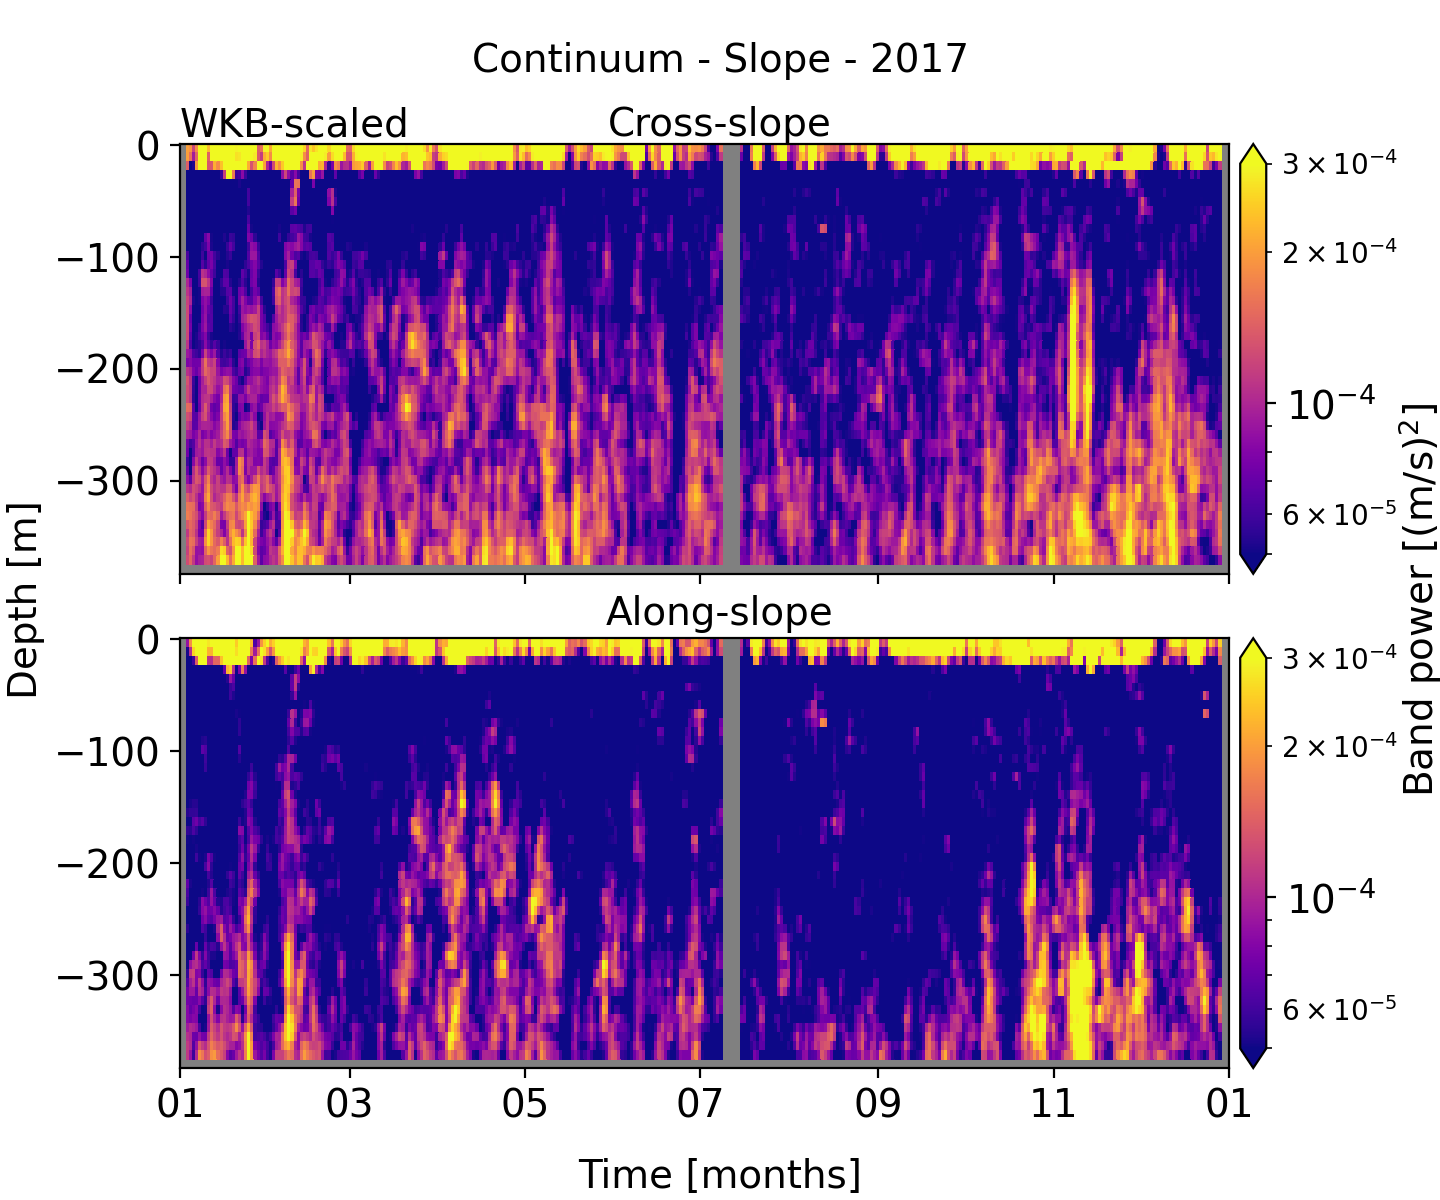

In [56]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
        

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_SN, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_SN, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

#plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

## Barotropic comparison

In [57]:
# depth-average for each time step (run PSD process above, first)

if adcp == 'Slope':
    d_up = 6
elif adcp == 'Axis75':
    d_up = 45
elif adcp == 'Axis55':
    d_up = 34

u_PSD_avg, v_PSD_avg = [],[]
for i in range(n_seg):
    ds_temp_u = xr.DataArray(u_WKB[i][d_up:],dims=('depth','time'))
    ds_temp_v = xr.DataArray(v_WKB[i][d_up:],dims=('depth','time'))
    u_avg_temp = ds_temp_u.mean(dim='depth')
    v_avg_temp = ds_temp_v.mean(dim='depth')
    u_PSD_avg.append(u_avg_temp)
    v_PSD_avg.append(v_avg_temp)
    
# get magnitudes
U = []
for i in range(n_seg):
    U.append(np.hypot(u_PSD_avg[i],v_PSD_avg[i]))  
    
print(f'Upper depth at -{depth[d_up]} m')

Upper depth at -51 m


In [58]:
# divide into 3-month chunks

start_dates_dt64ns = np.array([f'{t_stamp}-01-01', f'{t_stamp}-04-01', f'{t_stamp}-07-01', f'{t_stamp}-10-01'], dtype='datetime64[ns]')
end_dates_dt64ns = np.array([f'{t_stamp}-04-01', f'{t_stamp}-07-01', f'{t_stamp}-10-01', f'{t_stamp+1}-01-01'], dtype='datetime64[ns]')
start_dates_dt64D = start_dates_dt64ns.astype('datetime64[D]')
end_dates_dt64D = end_dates_dt64ns.astype('datetime64[D]')
start_dates = start_dates_dt64ns.astype('float')
end_dates = end_dates_dt64ns.astype('float')

corrU = []
corrT = []
for i in range(len(start_dates)):
    corrUi = []
    corrTi = []
    for j in range(n_seg):
        corrUj = []
        corrTj = []
        for k in range(len(ds[j].spect_SN)):
            tk = ds[j].spect_SN[k].values
            tk = tk.astype('float')
            if tk >= start_dates[i] and tk <= end_dates[i]:
                corrUj.append(float(U[j][k].values))
                corrTj.append(tk)
        corrUi.append(corrUj)
        corrTi.append(corrTj)
    corrU.append(corrUi)
    corrT.append(corrTi)

# corrT[section][n_seg][time_step]

In [61]:
# get phase-lag correlation

step_t = 92699          # seconds between 'samples'
spring_neap = 1180310   # spring-neap period in seconds (13.661 days)
if f_name == 'Continuum':
    dst = xr.open_dataset(f'../Data/tide/tide_Diurnal_{t_stamp}.nc')
else:
    dst = xr.open_dataset(f'../Data/tide/tide_{f_name}_{t_stamp}.nc')
td_float = dst.time.astype('float')

phase_lag = []
xcorr_lag = []
for i in range(len(start_dates)):
    phase_lag_i = []
    xcorr_lag_i = []
    print(f'Interval {i}: {start_dates_dt64D[i]} to {end_dates_dt64D[i]}')
    for j in range(n_seg):
        if not corrT[i][j]:
            phase_lag_j = []
            phase_lag_i.append(phase_lag_j)
            xcorr_lag_j = []
            xcorr_lag_i.append(xcorr_lag_j)
            continue
        else:
            bt_float = corrT[i][j]                         # convert datetime64 to float (above) for interpolation and cross-correlation
            bt_amp = corrU[i][j]
            td_amp = np.interp(x=bt_float,xp=td_float.values,fp=dst.tide.values)     # interpolate to match lower resolution data time stamps

            # get cross-correlation phase lag
            xcorr = sig.correlate(bt_amp, td_amp)
            xcorr_lag_i.append(xcorr)
            nsamples = len(bt_float)           # length of time series in steps
            tmax = nsamples*step_t             # length of time series in seconds
            t = np.linspace(0.0, tmax, nsamples, endpoint=False)
            delta_t = np.linspace(-t[-1], t[-1], 2*nsamples-1)
            recovered_time_shift = delta_t[xcorr.argmax()]     # peak of xcorr gives phase lag
            recovered_phase_shift = 2*np.pi*(((0.5 + (recovered_time_shift/spring_neap)) % 1.0) - 0.5) / np.pi
            relative_phase_shift = (recovered_phase_shift*np.pi) / (2*np.pi)
            relative_time_shift = relative_phase_shift * 13.661
            print(f"Phase shift {j}: %.2f pi, or %.2f spring-neap periods." % (recovered_phase_shift, relative_phase_shift))
            print(f'Recovered time shift {j}: %.2f seconds, or %.2f days.' % (recovered_time_shift, relative_time_shift))
            print('---')
            phase_lag_i.append(relative_time_shift)
            
    phase_lag.append(phase_lag_i)
    xcorr_lag.append(xcorr_lag_i)

Interval 0: 2017-01-01 to 2017-04-01
Phase shift 0: -0.47 pi, or -0.24 spring-neap periods.
Recovered time shift 0: -278097.00 seconds, or -3.22 days.
---
Interval 1: 2017-04-01 to 2017-07-01
Phase shift 0: 0.00 pi, or 0.00 spring-neap periods.
Recovered time shift 0: 0.00 seconds, or 0.00 days.
---
Interval 2: 2017-07-01 to 2017-10-01
Phase shift 0: 0.00 pi, or 0.00 spring-neap periods.
Recovered time shift 0: 0.00 seconds, or 0.00 days.
---
Phase shift 1: 0.63 pi, or 0.31 spring-neap periods.
Recovered time shift 1: 370796.00 seconds, or 4.29 days.
---
Interval 3: 2017-10-01 to 2018-01-01
Phase shift 1: 0.63 pi, or 0.31 spring-neap periods.
Recovered time shift 1: 370796.00 seconds, or 4.29 days.
---


<IPython.core.display.Javascript object>


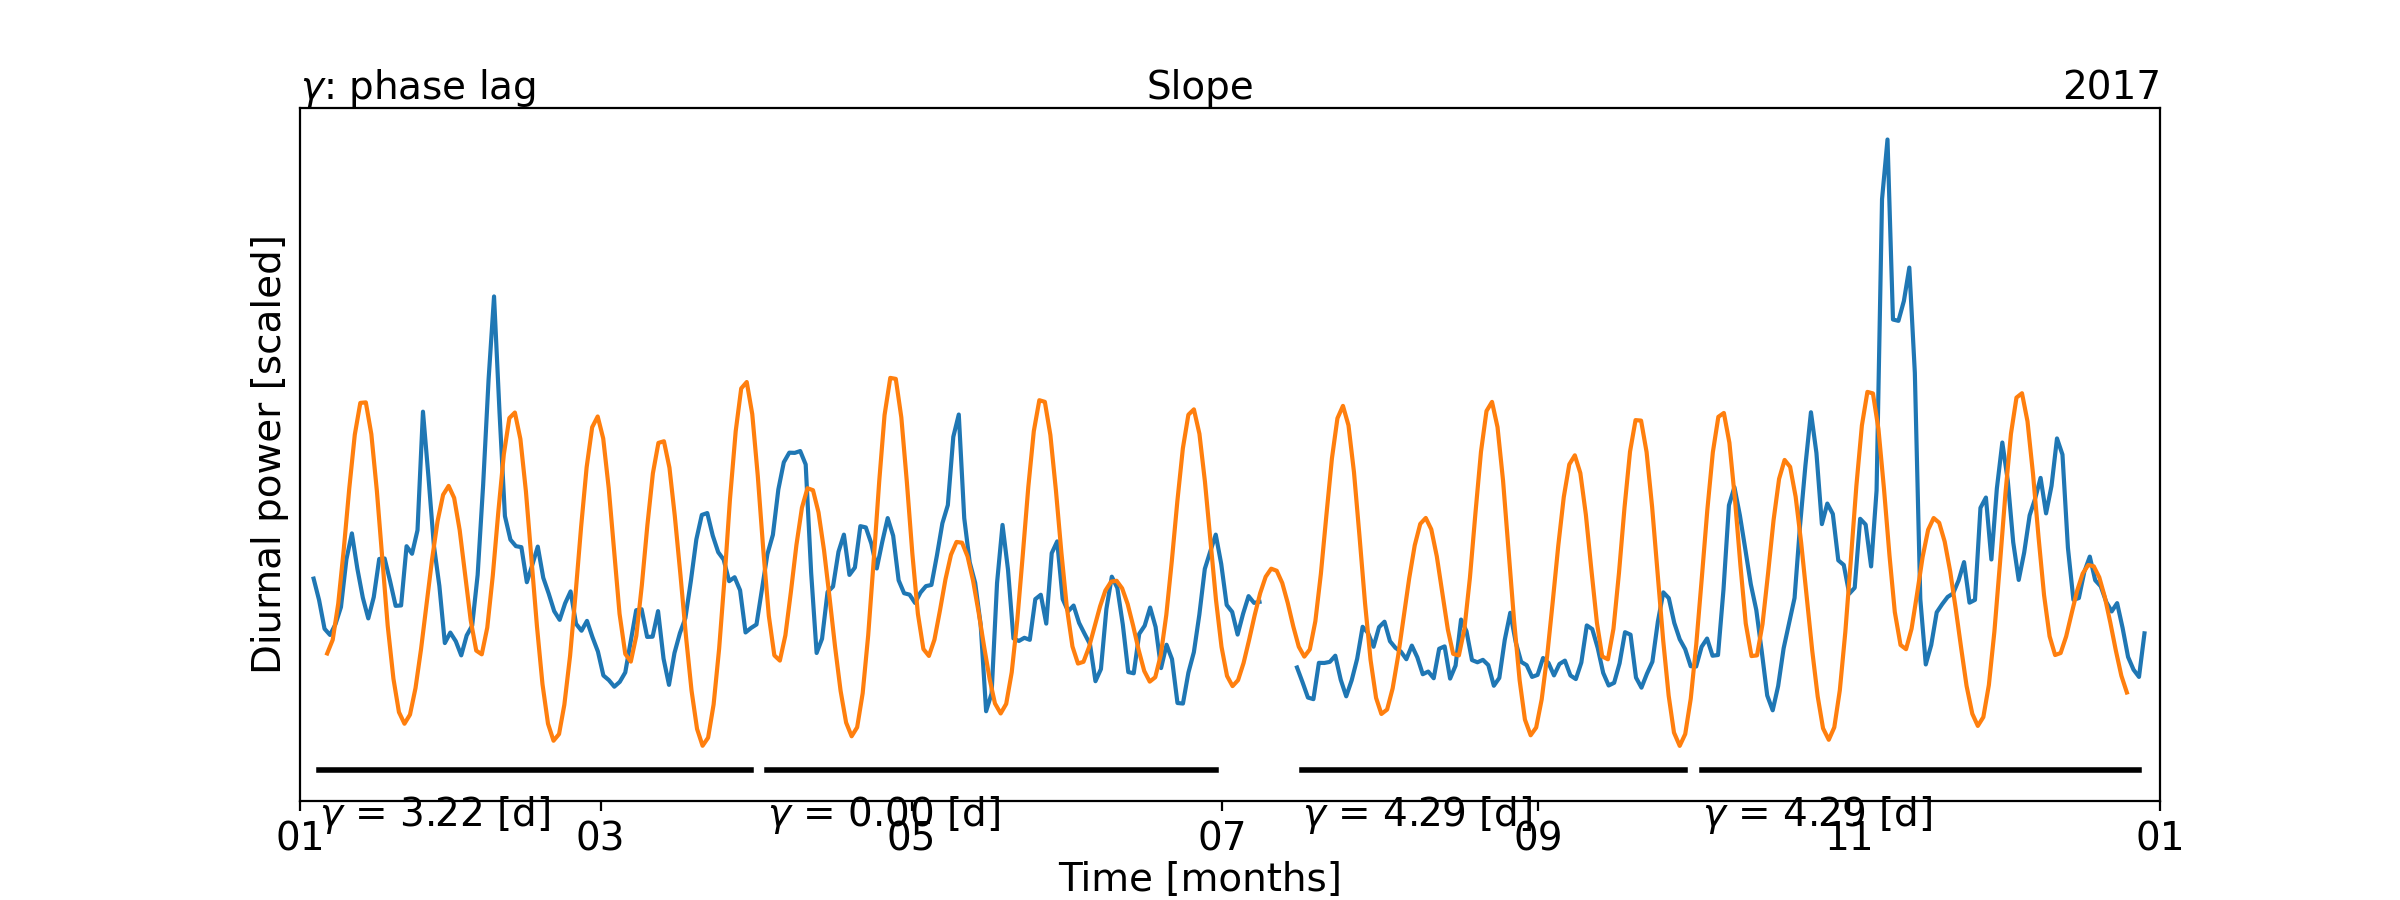

In [64]:
# check barotropic vs surface tides

fig,ax = plt.subplots(1,1,figsize=(12,4.5))

fig.text(0.88, 0.89, f'{t_stamp}', ha='center', fontsize=14)
fig.text(0.5, 0.89, f'{adcp}', ha='center', fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)  
fig.text(0.125,0.89,r'$\gamma$: phase lag',fontsize=14)

if t_stamp == 2013:
    if f_name == 'Diurnal' and adcp == 'Slope':
        scale = 5e2
    elif f_name == 'Diurnal' and adcp == 'Axis75':
        scale = 1e2
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        scale = 1.1e3
    elif f_name == 'Semidiurnal' and adcp == 'Axis75':
        scale = 3.5e2
elif t_stamp == 2014:
    if f_name == 'Diurnal' and adcp == 'Slope':
        scale = 6e2
    elif f_name == 'Diurnal' and adcp == 'Axis75':
        scale = 1e2
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        scale = 1.1e3
    elif f_name == 'Semidiurnal' and adcp == 'Axis75':
        scale = 7e2
elif t_stamp == 2017:
    if f_name == 'Diurnal' and adcp == 'Slope':
        scale = 6e2
    elif f_name == 'Diurnal' and adcp == 'Axis55':
        scale = 1.3e2
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        scale = 1.2e3
    elif f_name == 'Semidiurnal' and adcp == 'Axis55':
        scale = 3e2
elif t_stamp == 2018:
    if f_name == 'Diurnal' and adcp == 'Slope':
        scale = 6e2
    elif f_name == 'Diurnal' and adcp == 'Axis55':
        scale = 1.2e2
    elif f_name == 'Semidiurnal' and adcp == 'Slope':
        scale = 1.2e3
    elif f_name == 'Semidiurnal' and adcp == 'Axis55':
        scale = 5e2

#sci = "{:.1e}".format(scale)  
if f_name == 'Diurnal':
    L1 = 0
    L2 = -0.014
    for i in range(n_seg):
        if i == 0:
            bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue') #label=fr'{adcp}: depth-mean diurnal power [(m/s)$^2$] $\times$ {sci}',
        elif i > 0:
            bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue')
    td = ax.plot(dst.time,dst.tide,color='tab:orange') #label=r'Tofino: diurnal surface level power [m$^2$]',
elif f_name == 'Semidiurnal':
    L1 = 0.1
    L2 = 0
    for i in range(n_seg):
        if i == 0:
            bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue') #label=fr'{adcp}: depth-mean semidiurnal power [(m/s)$^2$] $\times$ {sci}',
        elif i > 0:
            bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue')
    td = ax.plot(dst.time,dst.tide,color='tab:orange') #label=r'Tofino: semidiurnal surface level power [m$^2$]',    
elif f_name == 'Continuum':
    L1 = 0.1
    L2 = 0
    scale = 4000
    for i in range(n_seg):
        if i == 0:
            bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue') #label=fr'{adcp}: depth-mean semidiurnal power [(m/s)$^2$] $\times$ {sci}',
        elif i > 0:
            bt = ax.plot(ds[i].spect_SN,U[i]*scale,color='tab:blue')
    td = ax.plot(dst.time,dst.tide,color='tab:orange') #label=r'Tofino: semidiurnal surface level power [m$^2$]',
    
for i in range(len(start_dates)):
    for j in range(n_seg):
        if not corrT[i][j]:
            continue
        elif len(corrT[i][j]) < 30:
            continue
        else:
            ax.plot(np.asarray(corrT[i][j][1:-1]).astype('datetime64[ns]'), np.full((len(corrT[i][j][1:-1])),L1), color='black',lw=2)
            plt.text(corrT[i][j][1].astype('datetime64[ns]'),L2,fr'$\gamma$ = %.2f [d]'%abs(phase_lag[i][j]),fontsize=14)

date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)
start = np.datetime64(f'{t_stamp}-01-01')
end = np.datetime64(f'{t_stamp+1}-01-01')
ax.set_xlim(start,end)
if f_name == 'Diurnal':
    ax.set_ylim(-0.02,0.22)
elif f_name == 'Semidiurnal':
    ax.set_ylim(-0.05,0.9)
ax.tick_params(labelsize=14)
ax.set_ylabel('Diurnal power [scaled]',fontsize=14)
ax.axes.yaxis.set_ticks([])

#plt.legend(fontsize=14,loc='lower left',frameon=False)
plt.show()

#plt.savefig(fname=f'./archive/tide/tide_{adcp}_{f_name}_{t_stamp}.pdf',format='pdf')

In [97]:
# save tide correlation data to .nc for inter-annual comparison

n_corr = len(start_dates)

for i in range(n_corr):
    for j in range(ds[0].n_seg):
        if not corrT[i][j]:
            continue
        elif len(corrT[i][j]) < 30:
            continue
        else:
            ds_out = xr.Dataset( 
                data_vars=dict(
                    #U=(['U_t'], U[i]),        # low-pass data
                    #tide=(['tide_t'], dst.tide.values),
                ),
                coords=dict(
                    corrT=np.asarray(corrT[i][j]).astype('datetime64[ns]'),           # datetime values in segments
                    phase_lag=phase_lag[i][j],           # datetime values in segments
                ),
                attrs=dict(
                    description=f'Tide correlation data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
                    adcp=adcp,                   # adcp
                    #upidx=upidx,                 # upper depth index
                    #lowidx=lowidx,               # lower depth index
                    #dup_stamp=dup_stamp,         # upper depth stamp
                    #dlow_stamp=dlow_stamp,       # lower depth stamp
                    t_stamp=t_stamp,             # year stamp
                    start_date=f'{start_date}',  # start date
                    end_date=f'{end_date}',      # end date
                    #t=t,                         # length of time series
                    #d=d,                         # length of depth series
                    n_corr=n_corr,
                    n_seg=ds[0].n_seg,                 # total number of segments
                ),
            ) 
            ds_out.to_netcdf(f'./archive/tide/{f_name}_corr_{adcp}_{t_stamp}_{i}{j}.nc')

for i in range(ds[0].n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            U=(['U_t'], U[i]),        # low-pass data
            tide=(['tide_t'], dst.tide.values),
        ),
        coords=dict(
            U_t=ds[i].spect_SN.values,           # datetime values in segments
            tide_t=dst.time.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Tide comparison data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=ds[0].n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'./archive/tide/{f_name}_comp_{adcp}_{t_stamp}_{i}.nc')

## Inter-annual comparisons

In [144]:
# load inter-annual data

f_name='Semidiurnal'
site='Slope'

if site == 'Slope':
    comp_slope_2013 = []
    corr_slope_2013 = []
    comp_slope_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Slope_2013_0.nc'))
    corr_slope_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2013_00.nc'))
    corr_slope_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2013_10.nc'))
    corr_slope_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2013_20.nc'))
    corr_slope_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2013_30.nc'))
    comp_slope_2014 = []
    corr_slope_2014 = []
    comp_slope_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Slope_2014_0.nc'))
    corr_slope_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2014_00.nc'))
    corr_slope_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2014_10.nc'))
    corr_slope_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2014_20.nc'))
    corr_slope_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2014_30.nc'))
    comp_slope_2017 = []
    corr_slope_2017 = []
    comp_slope_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Slope_2017_0.nc'))
    comp_slope_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Slope_2017_1.nc'))
    corr_slope_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2017_00.nc'))
    corr_slope_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2017_10.nc'))
    corr_slope_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2017_21.nc'))
    corr_slope_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2017_31.nc'))
    comp_slope_2018 = []
    corr_slope_2018 = []
    comp_slope_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Slope_2018_0.nc'))
    corr_slope_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2018_00.nc'))
    corr_slope_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2018_10.nc'))
    corr_slope_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2018_20.nc'))
    corr_slope_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Slope_2018_30.nc'))
elif site == 'Axis':
    comp_axis_2013 = []
    corr_axis_2013 = []
    comp_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis75_2013_0.nc'))
    comp_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis75_2013_1.nc'))
    corr_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2013_00.nc'))
    corr_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2013_10.nc'))
    corr_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2013_11.nc'))
    corr_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2013_21.nc'))
    corr_axis_2013.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2013_31.nc'))
    comp_axis_2014 = []
    corr_axis_2014 = []
    comp_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis75_2014_0.nc'))
    comp_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis75_2014_1.nc'))
    comp_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis75_2014_2.nc'))
    corr_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2014_00.nc'))
    corr_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2014_01.nc'))
    corr_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2014_11.nc'))
    corr_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2014_12.nc'))
    corr_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2014_22.nc'))
    corr_axis_2014.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis75_2014_32.nc'))
    comp_axis_2017 = []
    corr_axis_2017 = []
    comp_axis_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis55_2017_0.nc'))
    comp_axis_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis55_2017_1.nc'))
    corr_axis_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2017_00.nc'))
    corr_axis_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2017_10.nc'))
    corr_axis_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2017_21.nc'))
    corr_axis_2017.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2017_31.nc'))
    comp_axis_2018 = []
    corr_axis_2018 = []
    comp_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis55_2018_0.nc'))
    comp_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis55_2018_1.nc'))
    comp_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis55_2018_2.nc'))
    comp_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_comp_Axis55_2018_3.nc'))
    corr_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2018_00.nc'))
    corr_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2018_10.nc'))
    corr_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2018_22.nc'))
    corr_axis_2018.append(xr.open_dataset(f'./archive/tide/{f_name}_corr_Axis55_2018_32.nc'))

<IPython.core.display.Javascript object>


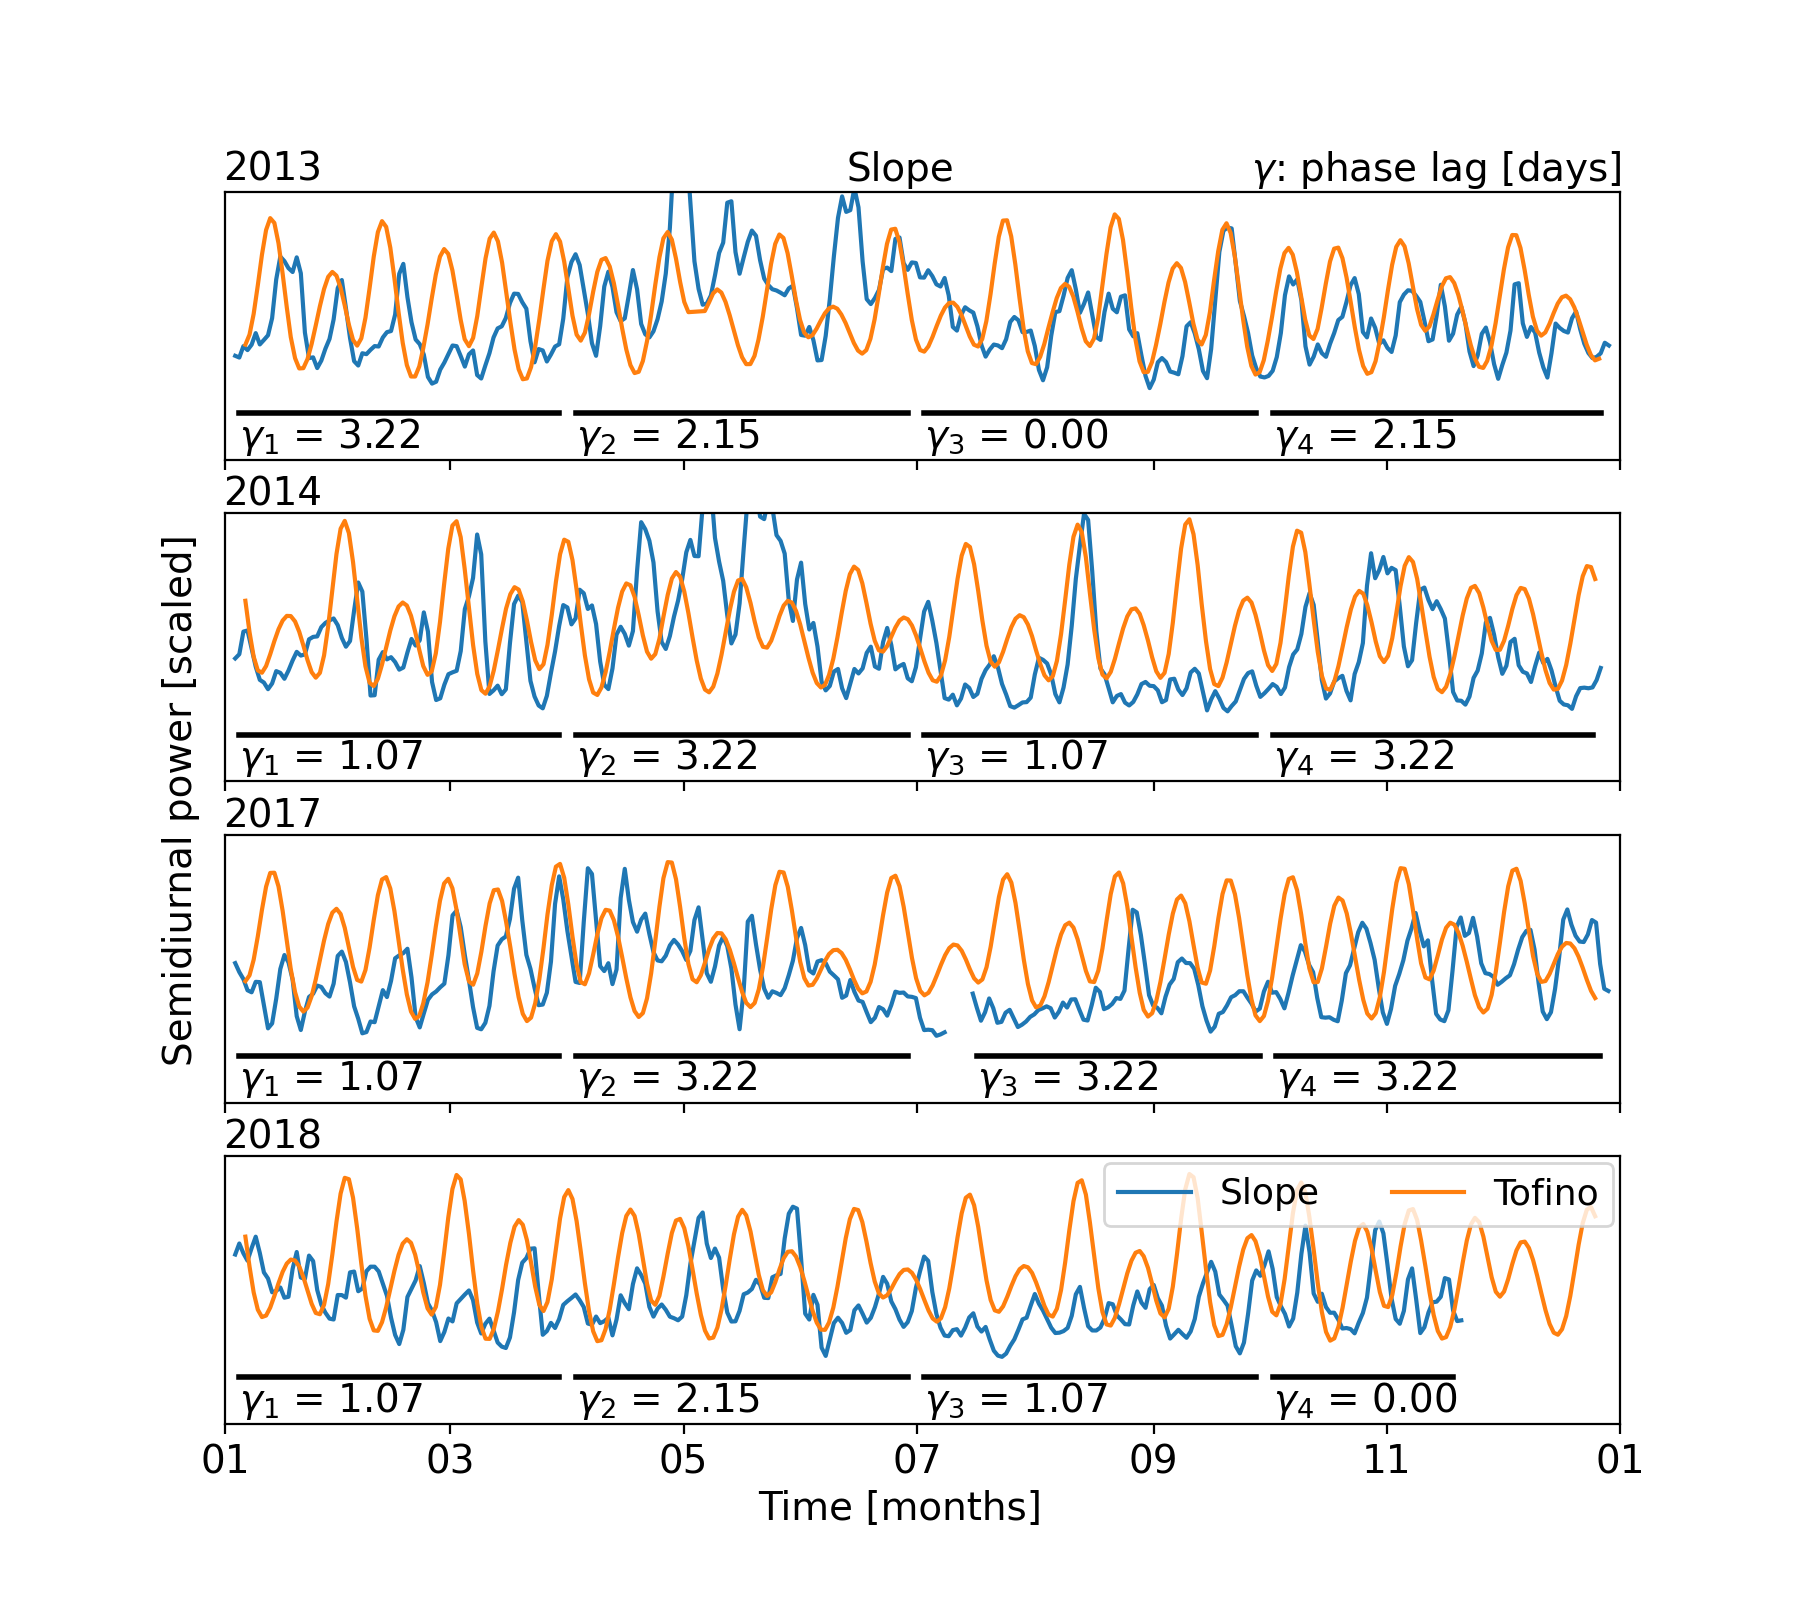

In [145]:
# check barotropic vs surface tides

fig,[ax0,ax1,ax2,ax3] = plt.subplots(4,1,figsize=(9,8),sharey=True)

#fig.text(0.88, 0.89, f'{t_stamp}', ha='center', fontsize=14)
fig.text(0.5, 0.887, f'{site}', ha='center', fontsize=14)
fig.text(0.5, 0.05, 'Time [months]', ha='center',fontsize=14)  
fig.text(0.695,0.887,r'$\gamma$: phase lag [days]',fontsize=14)
fig.text(0.124,0.887,'2013',fontsize=14)
fig.text(0.124,0.684,'2014',fontsize=14)
fig.text(0.124,0.483,'2017',fontsize=14)
fig.text(0.124,0.282,'2018',fontsize=14)
fig.text(0.09,0.5,f'{f_name} power [scaled]',va='center',rotation='vertical',fontsize=14)
date_form = pldates.DateFormatter("%m")
fig.subplots_adjust(hspace=0.2)

axes = [ax0,ax1,ax2,ax3]
if site == 'Slope':
    corr_site = [corr_slope_2013,corr_slope_2014,corr_slope_2017,corr_slope_2018]
    comp_site = [comp_slope_2013,comp_slope_2014,comp_slope_2017,comp_slope_2018]
    if f_name == 'Diurnal':
        scale=500
    elif f_name == 'Semidiurnal':
        scale=800
elif site == 'Axis':
    corr_site = [corr_axis_2013,corr_axis_2014,corr_axis_2017,corr_axis_2018]
    comp_site = [comp_axis_2013,comp_axis_2014,comp_axis_2017,comp_axis_2018]
    if f_name == 'Diurnal':
        scale=100
    elif f_name == 'Semidiurnal':
        scale=200

    
for j,k in enumerate(comp_site):
    for i in range(k[0].n_seg):
        if i == 0:
            bt = axes[j].plot(k[i].U_t,k[i].U*scale,color='tab:blue',label=f'{site}') 
            #label=fr'{adcp}: depth-mean diurnal power [(m/s)$^2$] $\times$ {sci}',
        elif i > 0:
            bt = axes[j].plot(k[i].U_t,k[i].U*scale,color='tab:blue')
    td = axes[j].plot(k[i].tide_t,k[i].tide,color='tab:orange',label='Tofino') 
    #label=r'Tofino: diurnal surface level power [m$^2$]', 
    start = np.datetime64(f'{k[0].t_stamp}-01-01')
    end = np.datetime64(f'{k[0].t_stamp+1}-01-01')
    axes[j].set_xlim(start,end)
    axes[j].xaxis.set_major_formatter(date_form)
    axes[j].tick_params(labelsize=14)
    axes[j].axes.yaxis.set_ticks([])

if f_name == 'Diurnal':
    ax0.set_ylim(-0.05,0.21)
    L1 = 0
    L2 = -0.035
    if site == 'Slope':
        ax2.legend(fontsize=14,loc=[0.63,0.55],frameon=False)
    elif site == 'Axis':
        ax2.legend(fontsize=14,loc=[0.13,0.55],frameon=False)
elif f_name == 'Semidiurnal':
    ax0.set_ylim(-0.19,0.9)
    L1 = 0
    L2 = -0.14
    if site == 'Slope':
        ax3.legend(fontsize=13,loc=[0.63,0.74],frameon=True,ncol=2,framealpha=0.8)
    elif site == 'Axis':
        ax2.legend(fontsize=14,loc=[0.13,0.55],frameon=False)
    
for j,k in enumerate(corr_site):
    for i in range(k[0].n_corr):
        if site == 'Axis' and k[0].t_stamp == 2013:
            if i == 0:
                axes[j].plot(k[0].corrT[1:-2],np.full((len(k[0].corrT[1:-2])),L1),color='black',lw=2)
                axes[j].text(k[0].corrT[1],L2,fr'$\gamma_{1}$ = %.2f'%k[0].phase_lag,fontsize=14)
                #axes[j].plot(k[1].corrT[1:-2],np.full((len(k[1].corrT[1:-2])),L1),color='black',lw=2)
                #axes[j].text(k[1].corrT[1],L2,fr'$\gamma_{2}$ = %.2f'%k[1].phase_lag,fontsize=14)
                #axes[j].plot(k[2].corrT[1:-2],np.full((len(k[2].corrT[1:-2])),L1),color='black',lw=2)
                #axes[j].text(k[2].corrT[1],L2,fr'$\gamma_{3}$ = %.2f'%k[2].phase_lag,fontsize=14)
                axes[j].plot(k[3].corrT[1:-2],np.full((len(k[3].corrT[1:-2])),L1),color='black',lw=2)
                axes[j].text(k[3].corrT[1],L2,fr'$\gamma_{3}$ = %.2f'%k[3].phase_lag,fontsize=14)
                axes[j].plot(k[4].corrT[1:-2],np.full((len(k[4].corrT[1:-2])),L1),color='black',lw=2)
                axes[j].text(k[4].corrT[1],L2,fr'$\gamma_{4}$ = %.2f'%k[4].phase_lag,fontsize=14)
        elif site == 'Axis' and k[0].t_stamp == 2014:
            if i == 0:
                axes[j].plot(k[0].corrT[1:-2],np.full((len(k[0].corrT[1:-2])),L1),color='black',lw=2)
                axes[j].text(k[0].corrT[1],L2,fr'$\gamma_{1}$ = %.2f'%k[0].phase_lag,fontsize=14)
                #axes[j].plot(k[1].corrT[1:-2],np.full((len(k[1].corrT[1:-2])),L1),color='black',lw=2)
                #axes[j].text(k[1].corrT[1],L2,fr'$\gamma_{2}$ = %.2f'%k[1].phase_lag,fontsize=14)
                #axes[j].plot(k[2].corrT[1:-2],np.full((len(k[2].corrT[1:-2])),L1),color='black',lw=2)
                #axes[j].text(k[2].corrT[1],L2,fr'$\gamma_{3}$ = %.2f'%k[2].phase_lag,fontsize=14)
                #axes[j].plot(k[3].corrT[1:-2],np.full((len(k[3].corrT[1:-2])),L1),color='black',lw=2)
                #axes[j].text(k[3].corrT[1],L2,fr'$\gamma_{3}$ = %.2f'%k[3].phase_lag,fontsize=14)
                axes[j].plot(k[4].corrT[1:-2],np.full((len(k[4].corrT[1:-2])),L1),color='black',lw=2)
                axes[j].text(k[4].corrT[1],L2,fr'$\gamma_{3}$ = %.2f'%k[4].phase_lag,fontsize=14)
                axes[j].plot(k[5].corrT[1:-2],np.full((len(k[5].corrT[1:-2])),L1),color='black',lw=2)
                axes[j].text(k[5].corrT[1],L2,fr'$\gamma_{4}$ = %.2f'%k[5].phase_lag,fontsize=14)
        else:
            axes[j].plot(k[i].corrT[1:-2], np.full((len(k[i].corrT[1:-2])),L1), color='black',lw=2)
            axes[j].text(k[i].corrT[1],L2,fr'$\gamma_{i+1}$ = %.2f'%k[i].phase_lag,fontsize=14)

for i in axes[0:-1]:
    i.axes.xaxis.set_ticklabels([])
    
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/tide_{f_name}_{site}.pdf',format='pdf')